# L layered Deep Neural Network

# Packages

In [212]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Dataset

In [213]:
X_train = np.loadtxt('dataset/cat/cat_train_x.csv', delimiter = ',')/255.0
Y_train = np.loadtxt('dataset/cat/cat_train_y.csv', delimiter = ',').reshape(1, X_train.shape[1])
X_test = np.loadtxt('dataset/cat/cat_test_x.csv', delimiter = ',')/255.0
Y_test = np.loadtxt('dataset/cat/cat_test_y.csv', delimiter = ',').reshape(1, X_test.shape[1])


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(12288, 209)
(1, 209)
(12288, 50)
(1, 50)


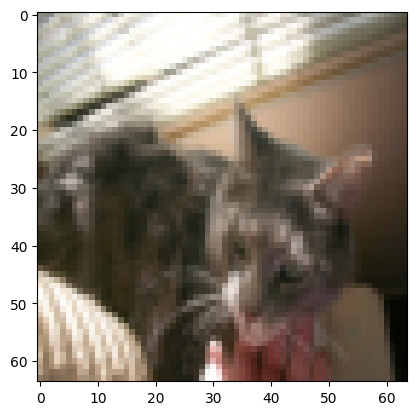

In [214]:
index = random.randrange(0, X_train.shape[1])
plt.imshow(X_train[:, index].reshape(64,64, 3))
plt.show()

# Activation Functions

In [215]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def softmax(z):
    expZ = np.exp(z)
    return expZ/(np.sum(expZ, 0))

def relu(Z):
    A = np.maximum(0,Z)
    return A

def tanh(x):
    return np.tanh(x)

def derivative_relu(Z):
    return np.array(Z > 0, dtype = 'float')

def derivative_tanh(x):
    return (1 - np.power(x, 2))

# Initialize Parameters

- We need to initialize the **W** parameters randomly, and **B** with zeros
- And as our Deep Neural network has **L layers**, we will repeat it for **L-1 times**, from $W_1 to W_L$

<img src="images/params.png" width="350"/>

In [216]:
def initialize_parameters(layer_dims):
    
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [217]:
layer_dims = [X_train.shape[0], 100, 200, Y_train.shape[0]]
params = initialize_parameters(layer_dims)

for l in range(1, len(layer_dims)):
    print("Shape of W" + str(l) + ":", params['W' + str(l)].shape)
    print("Shape of B" + str(l) + ":", params['b' + str(l)].shape, "\n")

Shape of W1: (100, 12288)
Shape of B1: (100, 1) 

Shape of W2: (200, 100)
Shape of B2: (200, 1) 

Shape of W3: (1, 200)
Shape of B3: (1, 1) 



#### Expected :

Shape of W1: (100, 12288)

Shape of B1: (100, 1) 

Shape of W2: (200, 100)

Shape of B2: (200, 1) 

Shape of W3: (1, 200)

Shape of B3: (1, 1)

# Forward Propagation


In [218]:
def forward_propagation(X, parameters, activation):
   
    forward_cache = {}
    L = len(parameters) // 2                  
    
    forward_cache['A0'] = X

    for l in range(1, L):
        forward_cache['Z' + str(l)] = parameters['W' + str(l)].dot(forward_cache['A' + str(l-1)]) + parameters['b' + str(l)]
        
        if activation == 'tanh':
            forward_cache['A' + str(l)] = tanh(forward_cache['Z' + str(l)])
        else:
            forward_cache['A' + str(l)] = relu(forward_cache['Z' + str(l)])
            

    forward_cache['Z' + str(L)] = parameters['W' + str(L)].dot(forward_cache['A' + str(L-1)]) + parameters['b' + str(L)]
    
    if forward_cache['Z' + str(L)].shape[0] == 1:
        forward_cache['A' + str(L)] = sigmoid(forward_cache['Z' + str(L)])
    else :
        forward_cache['A' + str(L)] = softmax(forward_cache['Z' + str(L)])
    
    return forward_cache['A' + str(L)], forward_cache

In [219]:
aL, forw_cache = forward_propagation(X_train, params, 'relu')

for l in range(len(params)//2 + 1):
    print("Shape of A" + str(l) + " :", forw_cache['A' + str(l)].shape)

Shape of A0 : (12288, 209)
Shape of A1 : (100, 209)
Shape of A2 : (200, 209)
Shape of A3 : (1, 209)


#### Expected :

Shape of A0 : (12288, 209)

Shape of A1 : (100, 209)

Shape of A2 : (200, 209)

Shape of A3 : (1, 209)

# Cost Function

#### For binary classification:
$ Cost = - \frac{1}{m} \sum_{i=1}^{m} [ y*log(a_L) + (1-y)*log(1 - a_L) ] $

#### For multi-class classification:

$ Cost = - \frac{1}{m} \sum_{i=1}^{m} \sum_{i=k}^{n}[ y_k*log(a_k) ]$

In [220]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    if Y.shape[0] == 1:
        cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    else:
        cost = -(1./m) * np.sum(Y * np.log(AL))
        
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

# Backward Propagation

- For last layer, **$dZ_L$** will be $A_L - Y$
- Except for last layer, we use a loop to implement backprop for other layers

<img src="images/backward_prop.png" width="300"/>

In [221]:
def backward_propagation(AL, Y, parameters, forward_cache, activation):
    
    grads = {}
    L = len(parameters)//2
    m = AL.shape[1]
    
    grads["dZ" + str(L)] = AL - Y
    grads["dW" + str(L)] = 1./m * np.dot(grads["dZ" + str(L)],forward_cache['A' + str(L-1)].T)
    grads["db" + str(L)] = 1./m * np.sum(grads["dZ" + str(L)], axis = 1, keepdims = True)
    
    for l in reversed(range(1, L)):
        if activation == 'tanh':
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_tanh(forward_cache['A' + str(l)])
        else:
            grads["dZ" + str(l)] = np.dot(parameters['W' + str(l+1)].T,grads["dZ" + str(l+1)])*derivative_relu(forward_cache['A' + str(l)])
            
        grads["dW" + str(l)] = 1./m * np.dot(grads["dZ" + str(l)],forward_cache['A' + str(l-1)].T)
        grads["db" + str(l)] = 1./m * np.sum(grads["dZ" + str(l)], axis = 1, keepdims = True)

    return grads

In [222]:
grads = backward_propagation(forw_cache["A" + str(3)], Y_train, params, forw_cache, 'relu')

for l in reversed(range(1, len(grads)//3 + 1)):
    print("Shape of dZ" + str(l) + " :", grads['dZ' + str(l)].shape)
    print("Shape of dW" + str(l) + " :", grads['dW' + str(l)].shape)
    print("Shape of dB" + str(l) + " :", grads['db' + str(l)].shape, "\n")

Shape of dZ3 : (1, 209)
Shape of dW3 : (1, 200)
Shape of dB3 : (1, 1) 

Shape of dZ2 : (200, 209)
Shape of dW2 : (200, 100)
Shape of dB2 : (200, 1) 

Shape of dZ1 : (100, 209)
Shape of dW1 : (100, 12288)
Shape of dB1 : (100, 1) 



#### Expected Output

Shape of dZ3 : (1, 209)

Shape of dW3 : (1, 200)

Shape of dB3 : (1, 1) 

Shape of dZ2 : (200, 209)

Shape of dW2 : (200, 100)

Shape of dB2 : (200, 1) 

Shape of dZ1 : (100, 209)

Shape of dW1 : (100, 12288)

Shape of dB1 : (100, 1) 

# Update Parameters
<img src="images/update_params.png" width="300"/>

In [223]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

# Predictions

In [224]:
def predict(X, y, parameters, activation):

    m = X.shape[1]
    y_pred, caches = forward_propagation(X, parameters, activation)
    
    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y = np.argmax(y, 0)
        y_pred = np.argmax(y_pred, 0)
    
    return np.sum((y_pred == y)/m)

In [225]:
def predict_result(X, y, parameters, activation):
    y_pred, caches = forward_propagation(X, parameters, activation)
    
    if y.shape[0] == 1:
        y_pred = np.array(y_pred > 0.5, dtype = 'float')
    else:
        y_pred = np.argmax(y_pred, 0)
    
    return y_pred

# Complete Model

Implement the entire Deep Neural Network here

### Instructions :

We need to initialize parameters once, and after that, we will run the following in a loop:
- forward_prop(x, parameters)
- cost_function(aL, y)
- backward_prop(x, y, parameters, forward_cache)
- parameters = update_parameters(parameters, gradients, learning_rate)

### Return :
- parameters, which will be our trained parameters

In [226]:
def model(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate=0.03, activation='relu', num_iterations=3000):
    np.random.seed(1)
    costs_train = []  # Danh sách để lưu cost của tập huấn luyện sau mỗi lần lặp
    costs_test = []   # Danh sách để lưu cost của tập kiểm tra sau mỗi lần lặp
    custom_time = []
    acc_train_list = []
    acc_test_list = []
    
    # Khởi tạo tham số
    parameters = initialize_parameters(layers_dims)

    for i in range(num_iterations):
        start_time = time.time()
        # Lan truyền tiến
        AL_train, forward_cache_train = forward_propagation(X_train, parameters, activation)
        AL_test, forward_cache_test = forward_propagation(X_test, parameters, activation)

        # Tính toán hàm lỗi (cost)
        cost_train = compute_cost(AL_train, Y_train)
        cost_test = compute_cost(AL_test, Y_test)

        # Lan truyền ngược
        grads = backward_propagation(AL_train, Y_train, parameters, forward_cache_train, activation)

        # Cập nhật tham số
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Lưu giá trị cost sau mỗi lần lặp
        costs_train.append(cost_train)
        costs_test.append(cost_test)

        train_acc = predict(X_train, Y_train, parameters, activation)
        test_acc = predict(X_test, Y_test, parameters, activation)

        acc_train_list.append(train_acc)
        acc_test_list.append(test_acc)

        # Hiển thị kết quả sau mỗi phần lặp (chia đều cho 10 lần hiển thị)
        if i % (num_iterations // 10) == 0:    
            print("\niter:{} \t train_cost: {} \t test_cost: {} \t train_acc:{} \t test_acc:{}".format(
                i, np.round(cost_train, 4), np.round(cost_test, 4), np.round(train_acc,4), np.round(test_acc,4)
            ))
        
        # In dấu "==" mỗi 10 lần lặp để theo dõi tiến trình
        if i % 10 == 0:
            print("==", end='')
        
        end_time = time.time()
        custom_time.append(end_time - start_time)

    return parameters, costs_train, costs_test, custom_time, acc_train_list, acc_test_list


In [227]:
layers_dims = [X_train.shape[0], 20, 7, 5, Y_train.shape[0]] #  4-layer model
lr = 0.0075
iters = 2500

parameters, costs_train, costs_test, custom_time, acc_train_list, acc_test_list = model(
    X_train, Y_train, 
    X_test, Y_test, 
    layers_dims, learning_rate = lr, 
    activation = 'relu', num_iterations = iters)
print(f"\nTổng thời gian chạy của Custom Model: {sum(custom_time):.2f}s")


iter:0 	 train_cost: 0.7717 	 test_cost: 0.6358 	 train_acc:0.512 	 test_acc:0.42
iter:250 	 train_cost: 0.6309 	 test_cost: 0.7152 	 train_acc:0.7416 	 test_acc:0.64
iter:500 	 train_cost: 0.5401 	 test_cost: 0.6638 	 train_acc:0.7847 	 test_acc:0.7
iter:750 	 train_cost: 0.4376 	 test_cost: 0.6143 	 train_acc:0.9234 	 test_acc:0.78
iter:1000 	 train_cost: 0.3152 	 test_cost: 0.5937 	 train_acc:0.9569 	 test_acc:0.8
iter:1250 	 train_cost: 0.2307 	 test_cost: 0.6742 	 train_acc:0.9761 	 test_acc:0.76
iter:1500 	 train_cost: 0.1612 	 test_cost: 0.6213 	 train_acc:0.9809 	 test_acc:0.82
iter:1750 	 train_cost: 0.1331 	 test_cost: 0.6644 	 train_acc:0.9809 	 test_acc:0.8
iter:2000 	 train_cost: 0.1138 	 test_cost: 0.7033 	 train_acc:0.9809 	 test_acc:0.8
iter:2250 	 train_cost: 0.1002 	 test_cost: 0.7131 	 train_acc:0.9809 	 test_acc:0.8
Tổng thời gian chạy của Custom Model: 47.67s


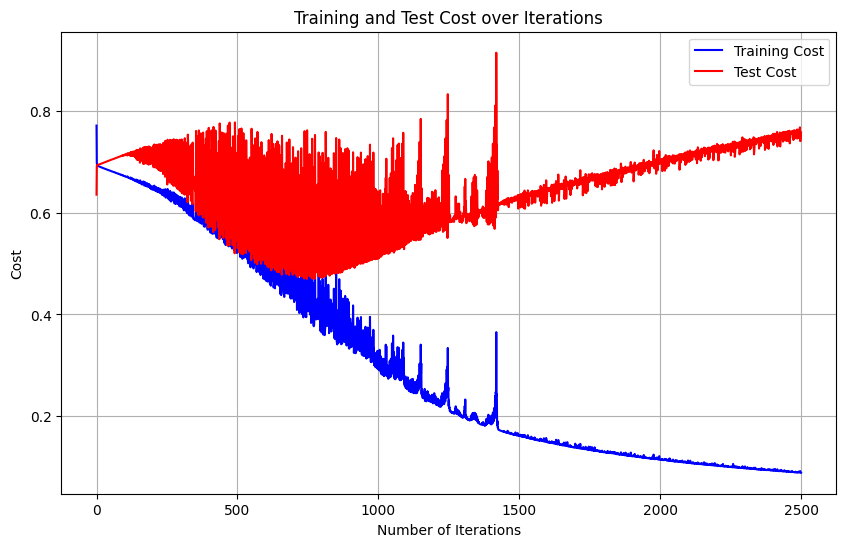

In [228]:
# Tạo danh sách các số lần lặp
plt.figure(figsize=(10, 6))
plt.plot(range(iters), costs_train, label='Training Cost', color='blue')
plt.plot(range(iters), costs_test, label='Test Cost', color='red')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.title('Training and Test Cost over Iterations')
plt.legend()
plt.grid(True)
plt.show()

Validation prediction

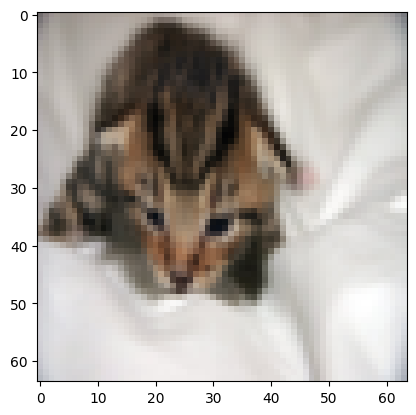

In [229]:
index = 1
plt.imshow(X_test[:, index].reshape(64,64, 3))
plt.show()

In [230]:
val_index = 1
val_predict = predict_result(X_test, Y_test, parameters, 'relu')
print("Predicted Value: ", val_predict[:, val_index])

Predicted Value:  [1.]


# Tensorflow

In [231]:
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

In [232]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((209, 12288), (209, 1), (50, 12288), (50, 1))

In [233]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback
import keras
from keras import layers

In [234]:
# Tạo callback tùy chỉnh để lưu thời gian sau mỗi epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []  # Lưu thời gian mỗi epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  # Bắt đầu đo thời gian

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time  # Tính thời gian epoch
        self.epoch_times.append(epoch_time)  # Lưu vào danh sách

In [235]:
# Khởi tạo callback
time_callback = TimeHistory()

In [236]:
# Khởi tạo mô hình
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(Y_train.shape[1], activation='sigmoid'))
optimizer = SGD(learning_rate=lr)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình và lưu lịch sử
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=iters, callbacks=[time_callback])

Epoch 1/2500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5919 - loss: 0.6847 - val_accuracy: 0.3400 - val_loss: 0.7235
Epoch 2/2500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6658 - loss: 0.6679 - val_accuracy: 0.3400 - val_loss: 0.7987
Epoch 3/2500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6521 - loss: 0.6579 - val_accuracy: 0.3400 - val_loss: 0.8096
Epoch 4/2500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6357 - loss: 0.6630 - val_accuracy: 0.3400 - val_loss: 0.8290
Epoch 5/2500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6851 - loss: 0.6259 - val_accuracy: 0.3400 - val_loss: 0.7831
Epoch 6/2500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6837 - loss: 0.6231 - val_accuracy: 0.4400 - val_loss: 0.7191
Epoch 7/2500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7102 - loss: 0.6209 - val_accuracy: 0.4200 - val_loss: 0.7365
Epoch 8/2500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6816 - loss: 0.6199 - val_accuracy: 0.5000 - val_los

Validation Prediction

In [237]:
# Dự đoán cho một mẫu cụ thể từ X_test
sample_index = 1  # Chọn mẫu thứ 1 trong X_test
sample = X_test[sample_index].reshape(1, -1)  # Đảm bảo mẫu có kích thước (1, số đặc trưng)

# Lấy kết quả dự đoán
predicted_output = model.predict(sample)
print(f"Dự đoán xác suất cho mẫu {sample_index}: {predicted_output}")

# Chuyển xác suất thành nhãn (nếu cần, cho bài toán nhị phân)
predicted_label = (predicted_output > 0.5).astype(int)
print(f"Nhãn dự đoán cho mẫu {sample_index}: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Dự đoán xác suất cho mẫu 1: [[0.9999883]]
Nhãn dự đoán cho mẫu 1: [[1]]


Chart

In [238]:
# Lấy danh sách thời gian sau mỗi epoch
tensorflow_time = time_callback.epoch_times
print("Thời gian mỗi epoch:", tensorflow_time)

# Tổng thời gian chạy
total_time = np.sum(tensorflow_time)
print(f"Tổng thời gian huấn luyện: {total_time:.2f} giây")

Thời gian mỗi epoch: [0.6252267360687256, 0.06351709365844727, 0.06499886512756348, 0.11800074577331543, 0.06699919700622559, 0.05999898910522461, 0.05999922752380371, 0.06699895858764648, 0.06999969482421875, 0.07299947738647461, 0.06299734115600586, 0.0650019645690918, 0.06399774551391602, 0.060999393463134766, 0.05699968338012695, 0.06399965286254883, 0.05999898910522461, 0.06000089645385742, 0.06999945640563965, 0.07400131225585938, 0.06899571418762207, 0.060001373291015625, 0.05800175666809082, 0.06000185012817383, 0.06499862670898438, 0.06000208854675293, 0.125, 0.07799863815307617, 0.058995723724365234, 0.0579984188079834, 0.06699705123901367, 0.09284019470214844, 0.06622743606567383, 0.05955147743225098, 0.06300115585327148, 0.06299400329589844, 0.06299853324890137, 0.06499767303466797, 0.059999704360961914, 0.07400083541870117, 0.0729978084564209, 0.06099700927734375, 0.06199955940246582, 0.06400036811828613, 0.06399679183959961, 0.06099891662597656, 0.0670015811920166, 0.0670

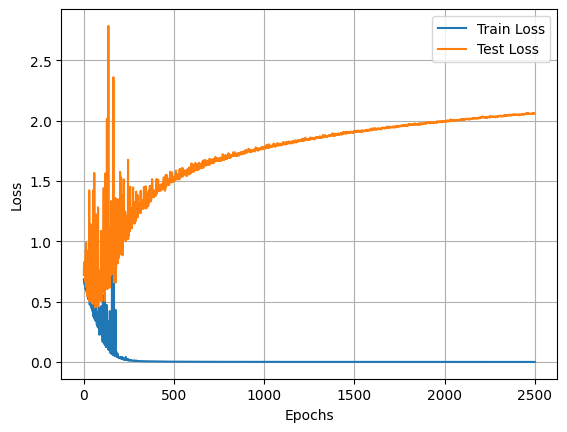

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7196 - loss: 2.1807
Test Loss: 2.0605, Test Accuracy: 0.7200


In [239]:

# Vẽ biểu đồ hàm lỗi sau khi huấn luyện
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

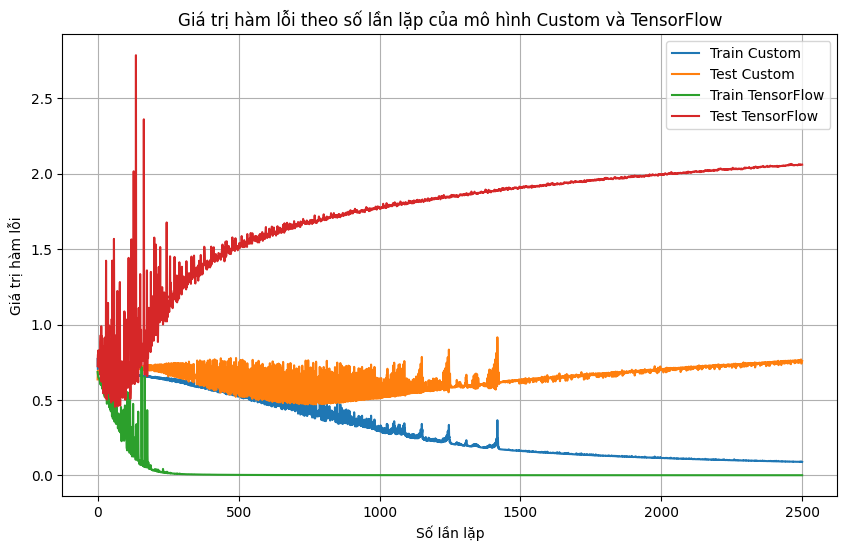

In [240]:
plt.figure(figsize=(10, 6))
plt.plot(costs_train, label='Train Custom')
plt.plot(costs_test, label='Test Custom')
plt.plot(history.history['loss'], label='Train TensorFlow')
plt.plot(history.history['val_loss'], label='Test TensorFlow')
plt.xlabel("Số lần lặp")
plt.ylabel("Giá trị hàm lỗi")
plt.legend()
plt.grid()
plt.title("Giá trị hàm lỗi theo số lần lặp của mô hình Custom và TensorFlow")   
plt.show()

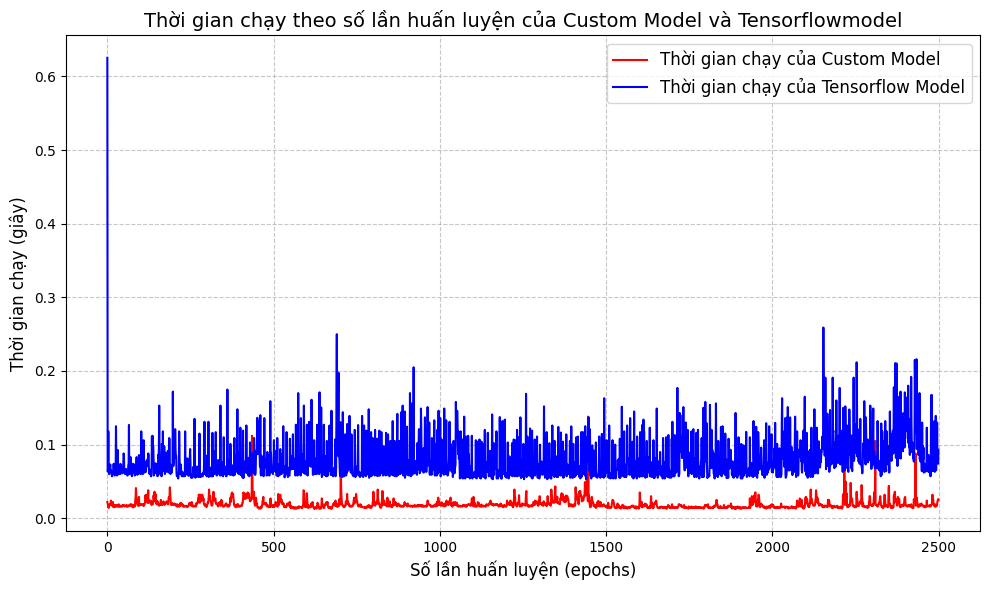

In [241]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(range(iters), custom_time, color='red', label='Thời gian chạy của Custom Model')
plt.plot(range(iters), tensorflow_time, color='blue', label='Thời gian chạy của Tensorflow Model')
plt.xlabel("Số lần huấn luyện (epochs)", fontsize=12)
plt.ylabel("Thời gian chạy (giây)", fontsize=12)
plt.title("Thời gian chạy theo số lần huấn luyện của Custom Model và Tensorflowmodel", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

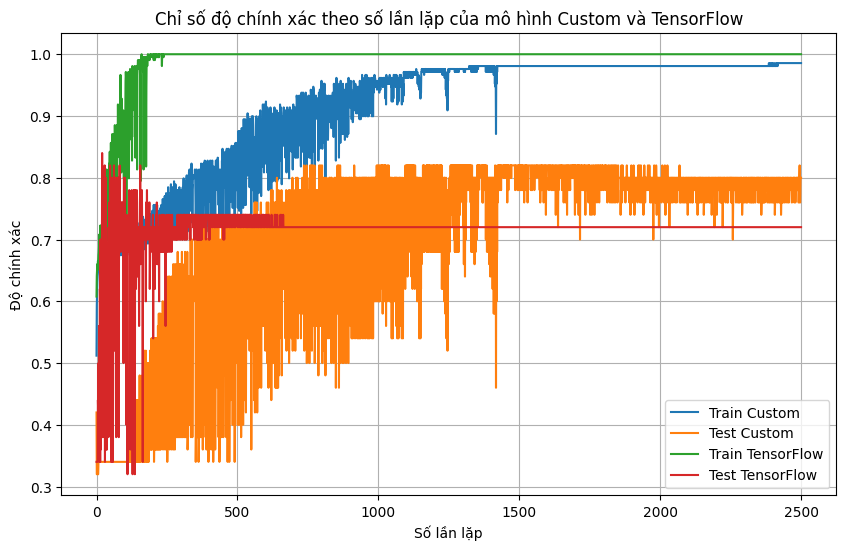

In [242]:
plt.figure(figsize=(10, 6))
plt.plot(acc_train_list, label='Train Custom')
plt.plot(acc_test_list, label='Test Custom')
plt.plot(history.history['accuracy'], label='Train TensorFlow')
plt.plot(history.history['val_accuracy'], label='Test TensorFlow')
plt.xlabel("Số lần lặp")
plt.ylabel("Độ chính xác")
plt.legend()
plt.grid()
plt.title("Chỉ số độ chính xác theo số lần lặp của mô hình Custom và TensorFlow")   
plt.show()